# A Cognitive Model or Harmonic Types (Simplified Amortization)

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Thesis/probabilistic_harmony_model

Mounted at /content/drive
/content/drive/MyDrive/Thesis/probabilistic_harmony_model


In [2]:
!pip install pyro-api==0.1.2
!pip install pyro-ppl==1.8.4
!pip install pitchtypes==0.4.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 730.7/730.7 kB 6.5 MB/s eta 0:00:00


In [3]:
import torch
import torch.nn as nn
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

from pyro.distributions import *
#from collections import Counter
import pyro.infer
import pyro.optim
import pyro.util
pyro.enable_validation(True)

import matplotlib.pyplot as plt
import tqdm

import numpy as np
import pandas as pd
import scipy.stats as stats

import os.path as path
from datetime import datetime
import json

import utils

import gc

In [4]:
gpu = torch.cuda.is_available()

gpu_n = 0

torch.set_default_dtype(torch.float64)

#torch.autograd.set_detect_anomaly(True)

device = torch.device(f'cuda:{gpu_n}' if gpu else 'cpu')
print(device)

cpu


In [5]:
def save_rng_state(name):
    fn = name + '-' + datetime.today().isoformat() + '.state'
    state = pyro.util.get_rng_state()
    with open('rng-' + fn, 'w') as f:
        print(state, file=f)
    torch.save(state['torch'], 'torch-' + fn)

In [6]:
# set random seeds
pyro.set_rng_seed(0)
#torch.set_deterministic(True)
#torch.set_num_threads(1)
#torch.set_num_interop_threads(1)

# fix the range of pitches we consider
fifth_range = 2*7                  # 2 diatonics
npcs = 2*fifth_range+1             # around C: Cbb to C## on LoF
utils.set_fifth_range(fifth_range) # used to make helper functions work correctly

# **1. Amortization**



## Step 1: Model

**Notations:**
- $h$: probablity distribution of chords (harmony)
- $\Phi$: chord profile for all chord types, where each $\phi_i$ conntains weights for each chord
- $npcs$: range of line of fifths, which is the number of pitches we consider
- $n_{harmonies}$: number of different chord types
- $n_{chords}$: length of dataset (how many chords we observe in the dataset)

**Generating Process:**

For all $i$:

- $\phi_i \sim Dirichlet(0.5, npcs)$
- $h \sim Dirichlet(0.5, n_{harmonies})$

    For each chord j:
    - Choose chords: $c_i \sim Categorical(h)$
    - Choose pitches: $p_j \sim Multinomial(\phi_{cj}, N_j)$

where $p_j$ and $N_j$ are observed, other variables are unobserved.

In [29]:
def simplified_chord_model(npcs, nharmonies, data, subsamples=500, **kwargs):
    # parameters priors:
    # distribution of the harmonies
    p_harmony = pyro.sample('p_harmony', dist.Dirichlet(1.5 * torch.ones(nharmonies, device=device)))
    # distribution of notes in the harmonies (chord profiles)
    with pyro.plate('harmonies', nharmonies):
        chord_profiles = pyro.sample('chord_profiles', dist.Dirichlet(1.5 * torch.ones(npcs, device=device)))

    # Sampling the data:
    nchords = len(data['c'])
    subs = torch.arange(min(nchords, subsamples), device=device) if subsamples is not None else torch.arange(nchords, device=device)

    with pyro.plate('data', nchords, subsample=subs) as ind:
        # sample a chord type based on the harmony distribution (to be inferred)
        c = pyro.sample('c', dist.Categorical(p_harmony))

        # sampling pitches for the chord based on the selected chord type profile
        pitches = pyro.sample('pitches', dist.Multinomial(1, probs=chord_profiles[c], validate_args=False), obs=data['pitches'][ind])

    return {"p_harmony": p_harmony, "chord_profiles": chord_profiles, "c": c, "pitches": pitches}

## Step 2: Amortization Guide for Inference


In [30]:
# simpler
class AmortizationNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.softmax(self.fc2(x), dim=-1)
        return x

In [31]:
# # with regulation
# class AmortizationNetwork(nn.Module):
#     def __init__(self, input_dim, hidden_dim, output_dim):
#         super().__init__()
#         self.fc1 = nn.Linear(input_dim, hidden_dim)
#         self.fc2 = nn.Linear(hidden_dim, output_dim)
#         self.dropout = nn.Dropout(p=0.5)

#     def forward(self, x):
#         x = torch.relu(self.fc1(x.float()))
#         x = self.dropout(x)
#         x = torch.softmax(self.fc2(x), dim=-1)
#         return x

In [32]:
# # more complex
# class AmortizationNetwork(nn.Module):
#     def __init__(self, input_dim, hidden_dim1, hidden_dim2, output_dim):
#         super().__init__()
#         self.fc1 = nn.Linear(input_dim, hidden_dim1)
#         self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
#         self.fc3 = nn.Linear(hidden_dim2, output_dim)
#         # self.dropout = nn.Dropout(p=0.5)

#     def forward(self, x):
#         x = torch.relu(self.fc1(x.float()))
#         # x = self.dropout(x)
#         x = torch.softmax(self.fc3(x), dim=-1)
#         return x

In [33]:
def amortization_guide(npcs, nharmonies, data, subsamples=500, **kwargs):
    # for the distribution of the harmonies
    # initialize alpha parameters with more information, assuming some harmonies might be more probable
    alpha_h = pyro.param('alpha_h', (torch.ones(nharmonies, device=device) * 1.5), constraint=constraints.positive)
    pyro.sample('p_harmony', dist.Dirichlet(alpha_h))

    # for the chord profiles
    with pyro.plate('harmonies', nharmonies):
        alpha_phi = pyro.param('alpha_phi', (torch.ones([nharmonies, npcs], device=device) * 1.5), constraint=constraints.positive)
        pyro.sample('chord_profiles', dist.Dirichlet(alpha_phi))

    # for chord types
    net = AmortizationNetwork(input_dim=npcs, hidden_dim=128, output_dim=nharmonies)
    # net = AmortizationNetwork(input_dim=npcs, hidden_dim1=128, hidden_dim2=64, output_dim=nharmonies)
    net.to(device)
    pyro.module("net", net)

    nchords = len(data['c'])
    subs = torch.arange(min(nchords, subsamples), device=device) if subsamples is not None else torch.arange(nchords, device=device)

    with pyro.plate('data', nchords, subsample=subs) as ind:
        # Use NN to predict parameters for the chord types
        chord_features = data['pitches']
        chord_type_params = net(chord_features[ind])
        pyro.sample('c', dist.Categorical(probs=chord_type_params))

## Step 3: Data and Conditioning
**Data Format**


In [34]:
def simplified_chord_tensor(notes):
    """Takes a list of fifths and returns a vector of counts for fifths."""
    chord = torch.zeros(npcs, device=device)
    for fifth in notes:
        index = utils.fifth_to_index(fifth)
        chord[index] += 1
    return chord

def simplified_annot_data_obs(chords):
    """Helper function to turn a list of chord dictionaries into a dictionary of observation vectors."""
    obs = {}
    obs["pitches"] = torch.cat([simplified_chord_tensor(c['notes']).reshape((1, -1)) for c in chords], dim=0)
    obs["c"] = torch.tensor([c['label'] for c in chords], device=device)
    obs["n"] = torch.tensor([len(c['notes']) - 1 for c in chords], device=device)
    return obs

**Loading the Dataset**

The data is loaded from a TSV file that. The resulting dataframe is converted to the observation format that we pass to the model.

In [35]:
def load_dataset(filename):
    filename = path.join("data", filename)
    print("loading dataset...")
    df = utils.load_csv(filename)
    sizes = df.groupby(['chordid', 'label']).size()
    type_counts = sizes.groupby('label').size().sort_values(ascending=False)
    chordtypes = type_counts.index.tolist()
    df['numlabel'] = df.label.map(chordtypes.index)

    # check if precomputed tensor data is available:
    prefn = filename + "_precomp.pt"
    if path.exists(prefn) and path.getmtime(prefn) > path.getmtime(filename):
        print("using precomputed tensor data.")
        obs = torch.load(prefn, map_location=device)
    else:
        print('extracting chords...')
        chords = [{'label': numlabel, 'notes': [row['fifth'] for index, row in grp.iterrows()]}
                  for (_, numlabel), grp in tqdm.tqdm(df.groupby(['chordid', 'numlabel']))]
        print('converting chords to tensors...')
        obs = simplified_annot_data_obs(chords)
        torch.save(obs, prefn)

    print(len(chordtypes), "chord types")
    print(len(obs["c"]), "chords")
    return df, obs, chordtypes

In [36]:
def get_init_params(df, nharms, npcs):
    init = dict()

    # initialize params for harmonies
    init['harmonies'] = torch.tensor(df.groupby('numlabel').size().sort_values(ascending=False), device=device) + 0.5

    # initialize params for chord profiles
    init['chord_profiles'] = torch.zeros([nharms, npcs], device=device) + 0.5
    for (numlabel, fifth), grp in df.groupby(['numlabel', 'fifth']):
        init['chord_profiles'][numlabel, utils.fifth_to_index(fifth)] += grp.fifth.count()

    chord_sizes = df.groupby('chordid').size()
    init['sum_chords'] = torch.tensor(sum(chord_sizes), device=device)
    init['n_chords'] = torch.tensor(len(chord_sizes), device=device)
    return init

After inferring the parameters we save them for easier inspection and reuse.



In [37]:
def save_params(params, nharmonies, npcs, name):
    # Save the PyTorch parameters
    torch.save(params , path.join("results", name + '.pt'))

    # Save the parameters in a JSON file for easy access
    with open(path.join("results", name + '.json'), 'w') as f:
        json.dump({'params': {key: val.tolist() for key, val in params.items()},
                   'nharmonies': nharmonies,
                   'npcs': npcs},
                  f)

## Step 4: Inference

In [38]:
def infer_amortized_posteriors(npcs, nharmonies, data, nsteps=5000, lr=0.01, step_size=100, clip_grad=0.1, plot_loss=True, save_as=None, collect_history=False):
    pyro.clear_param_store()
    pyro.set_rng_seed(1625)

    svi = pyro.infer.SVI(model=simplified_chord_model,
                         guide=lambda npcs, nharmonies, data: amortization_guide(npcs, nharmonies, data),
                         optim=pyro.optim.Adam({"lr": lr, "betas": (0.95, 0.999)}),
                         loss=pyro.infer.Trace_ELBO())

    losses = []
    alpha_h_history = []
    alpha_phi_history = []

    for step in tqdm.trange(nsteps):
        loss = svi.step(npcs, nharmonies, data)

        # check for NaNs and infs in gradients
        for name, param in pyro.get_param_store().items():
            if param.grad is not None:
                if torch.isnan(param.grad).any() or torch.isinf(param.grad).any():
                    raise ValueError(f'Gradient for {name} has NaN/inf values.')

        # apply gradient clipping
        for p in pyro.get_param_store().values():
            p.register_hook(lambda grad: torch.clamp(grad, -clip_grad, clip_grad))

        losses.append(loss)

        if collect_history:
            # collect parameter histories
            alpha_h_history.append(pyro.param('alpha_h').detach().cpu().numpy())
            alpha_phi_history.append(pyro.param('alpha_phi').detach().cpu().numpy())

        if step % 100 == 0:
            print(f"Step {step} : loss = {loss}")

    # plot the loss
    if plot_loss:
        plt.figure(figsize=(12, 5))
        plt.plot(losses)
        plt.xlabel("Iteration")
        plt.ylabel("Loss")
        plt.title(f"SVI Convergence ({save_as})")
        plt.show()

    # save inferred parameters
    params = {name: value.detach().cpu().numpy() for name, value in pyro.get_param_store().items()}

    if save_as is not None:
        save_params(params, nharmonies, npcs, save_as)

    return params, (alpha_h_history, alpha_phi_history) if collect_history else params

## Step 5: Plotting

In [39]:
def plot_param_histories(alpha_h_history, alpha_phi_history):
    # Plot alpha_h history
    plt.figure(figsize=(12, 5))
    plt.plot(alpha_h_history)
    plt.title('Alpha_h parameter history')
    plt.xlabel('Iteration')
    plt.ylabel('Alpha_h values')
    plt.show()

    # Plot alpha_phi history (for simplicity, here we just plot the mean over the pitch classes)
    alpha_phi_mean_history = np.mean(alpha_phi_history, axis=-1)  # Compute the mean over pitch classes
    plt.figure(figsize=(12, 5))
    plt.plot(alpha_phi_mean_history)
    plt.title('Mean Alpha_phi parameter history')
    plt.xlabel('Iteration')
    plt.ylabel('Mean Alpha_phi values')
    plt.show()

In [40]:
def plot_amortized_inference_results(params, nharmonies, npcs, save_as=None):
    # Extract harmony and chord profile parameters
    harmony_params = params['alpha_h']
    chord_profile_params = params['alpha_phi']

    # Normalize the parameters
    harmony_normalized = harmony_params / np.sum(harmony_params)
    chord_profile_normalized = np.array([cp / np.sum(cp) for cp in chord_profile_params])

    num_subplots = nharmonies + 1

    fig, axs = plt.subplots(num_subplots, 1, figsize=(12, 3 * num_subplots))

    # Plot harmony distribution
    axs[0].bar(np.arange(len(harmony_normalized)), harmony_normalized)
    axs[0].set_title('Harmony Distribution')
    axs[0].set_xlabel('Harmony Types')
    axs[0].set_ylabel('Probability')

    # Plot chord profile parameters for each harmony
    for i in range(nharmonies):
        axs[i + 1].bar(np.arange(npcs), chord_profile_normalized[i])
        axs[i + 1].set_title(f'Chord Profile for Harmony {i}')
        axs[i + 1].set_xlabel('Pitches')
        axs[i + 1].set_ylabel('Probability')

    plt.tight_layout()
    if save_as:
        plt.savefig(f"{save_as}.png")
    plt.show()

# **2. Experiment**

In [41]:
dcml_df, dcml_obs, dcml_chordtypes = load_dataset('dcml.tsv')
dcml_init = get_init_params(dcml_df, len(dcml_chordtypes), npcs)

loading dataset...
using precomputed tensor data.
14 chord types
113771 chords


  0%|          | 0/5000 [00:00<?, ?it/s]<ipython-input-38-390aaa289ab3>:19: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten/src/ATen/core/TensorBody.h:489.)
  if param.grad is not None:
  0%|          | 8/5000 [00:00<01:08, 73.15it/s]

Step 0 : loss = 3306932.322096385


  2%|▏         | 113/5000 [00:01<01:08, 70.93it/s]

Step 100 : loss = 1864769.0549391378


  4%|▍         | 209/5000 [00:02<01:08, 69.84it/s]

Step 200 : loss = 1823295.297039964


  6%|▋         | 316/5000 [00:04<01:04, 72.88it/s]

Step 300 : loss = 1830955.0694285296


  8%|▊         | 412/5000 [00:05<01:02, 73.50it/s]

Step 400 : loss = 1812781.899328488


 10%|█         | 508/5000 [00:07<01:01, 73.12it/s]

Step 500 : loss = 1819621.736374815


 12%|█▏        | 612/5000 [00:08<00:59, 73.36it/s]

Step 600 : loss = 1822673.5641258096


 14%|█▍        | 706/5000 [00:10<01:20, 53.08it/s]

Step 700 : loss = 1802842.4742113748


 16%|█▌        | 808/5000 [00:12<01:19, 52.98it/s]

Step 800 : loss = 1798173.8399686692


 18%|█▊        | 911/5000 [00:13<00:56, 72.04it/s]

Step 900 : loss = 1799296.4741302817


 20%|██        | 1013/5000 [00:15<00:56, 71.04it/s]

Step 1000 : loss = 1804658.5527661056


 22%|██▏       | 1109/5000 [00:16<00:53, 73.40it/s]

Step 1100 : loss = 1801963.690730015


 24%|██▍       | 1213/5000 [00:17<00:52, 72.50it/s]

Step 1200 : loss = 1806452.9908746318


 26%|██▌       | 1309/5000 [00:19<00:52, 70.56it/s]

Step 1300 : loss = 1796402.010295867


 28%|██▊       | 1413/5000 [00:20<00:50, 70.85it/s]

Step 1400 : loss = 1810968.1413553464


 30%|███       | 1509/5000 [00:21<00:46, 74.93it/s]

Step 1500 : loss = 1816324.8599685426


 32%|███▏      | 1609/5000 [00:23<01:06, 51.12it/s]

Step 1600 : loss = 1802501.6861772721


 34%|███▍      | 1711/5000 [00:25<00:57, 57.50it/s]

Step 1700 : loss = 1793652.9613721322


 36%|███▋      | 1813/5000 [00:27<00:43, 72.95it/s]

Step 1800 : loss = 1798540.576883975


 38%|███▊      | 1909/5000 [00:28<00:40, 75.70it/s]

Step 1900 : loss = 1792493.0747897017


 40%|████      | 2011/5000 [00:29<00:40, 73.86it/s]

Step 2000 : loss = 1791746.622720587


 42%|████▏     | 2115/5000 [00:31<00:41, 70.13it/s]

Step 2100 : loss = 1798658.2332185525


 44%|████▍     | 2211/5000 [00:32<00:36, 76.32it/s]

Step 2200 : loss = 1800025.0144986294


 46%|████▋     | 2316/5000 [00:33<00:34, 76.96it/s]

Step 2300 : loss = 1799566.0069776545


 48%|████▊     | 2408/5000 [00:35<00:34, 75.80it/s]

Step 2400 : loss = 1802766.503980384


 50%|█████     | 2508/5000 [00:36<00:49, 50.34it/s]

Step 2500 : loss = 1811167.5809967588


 52%|█████▏    | 2613/5000 [00:38<00:36, 65.93it/s]

Step 2600 : loss = 1810306.6838939246


 54%|█████▍    | 2709/5000 [00:40<00:32, 71.34it/s]

Step 2700 : loss = 1791957.9677873028


 56%|█████▋    | 2814/5000 [00:41<00:29, 73.05it/s]

Step 2800 : loss = 1807591.6328167808


 58%|█████▊    | 2910/5000 [00:43<00:31, 66.09it/s]

Step 2900 : loss = 1798115.452387136


 60%|██████    | 3010/5000 [00:44<00:29, 67.51it/s]

Step 3000 : loss = 1803920.3343894966


 62%|██████▏   | 3114/5000 [00:46<00:25, 74.59it/s]

Step 3100 : loss = 1802023.7464142162


 64%|██████▍   | 3211/5000 [00:47<00:24, 74.25it/s]

Step 3200 : loss = 1805196.4973188746


 66%|██████▌   | 3311/5000 [00:49<00:29, 57.30it/s]

Step 3300 : loss = 1812011.8993952028


 68%|██████▊   | 3409/5000 [00:50<00:30, 52.42it/s]

Step 3400 : loss = 1803864.4690928427


 70%|███████   | 3516/5000 [00:52<00:20, 74.14it/s]

Step 3500 : loss = 1794645.3644171956


 72%|███████▏  | 3612/5000 [00:53<00:19, 71.87it/s]

Step 3600 : loss = 1810167.5461255284


 74%|███████▍  | 3710/5000 [00:55<00:17, 75.05it/s]

Step 3700 : loss = 1794131.653162721


 76%|███████▋  | 3814/5000 [00:56<00:15, 75.83it/s]

Step 3800 : loss = 1801823.1187305648


 78%|███████▊  | 3911/5000 [00:57<00:14, 73.31it/s]

Step 3900 : loss = 1811553.8768625143


 80%|████████  | 4015/5000 [00:59<00:13, 71.35it/s]

Step 4000 : loss = 1795176.5566583977


 82%|████████▏ | 4111/5000 [01:00<00:12, 72.81it/s]

Step 4100 : loss = 1796691.0402987683


 84%|████████▍ | 4211/5000 [01:02<00:13, 56.76it/s]

Step 4200 : loss = 1799175.1659324754


 86%|████████▌ | 4307/5000 [01:03<00:12, 55.38it/s]

Step 4300 : loss = 1782739.5224819651


 88%|████████▊ | 4414/5000 [01:05<00:08, 67.82it/s]

Step 4400 : loss = 1809772.7033720508


 90%|█████████ | 4512/5000 [01:07<00:06, 79.14it/s]

Step 4500 : loss = 1812055.154939156


 92%|█████████▏| 4609/5000 [01:08<00:05, 74.54it/s]

Step 4600 : loss = 1794249.0821671882


 94%|█████████▍| 4714/5000 [01:09<00:03, 74.55it/s]

Step 4700 : loss = 1791273.266854262


 96%|█████████▌| 4810/5000 [01:11<00:02, 76.92it/s]

Step 4800 : loss = 1796558.9755495854


 98%|█████████▊| 4914/5000 [01:12<00:01, 71.45it/s]

Step 4900 : loss = 1798651.9633366684


100%|██████████| 5000/5000 [01:13<00:00, 67.94it/s]


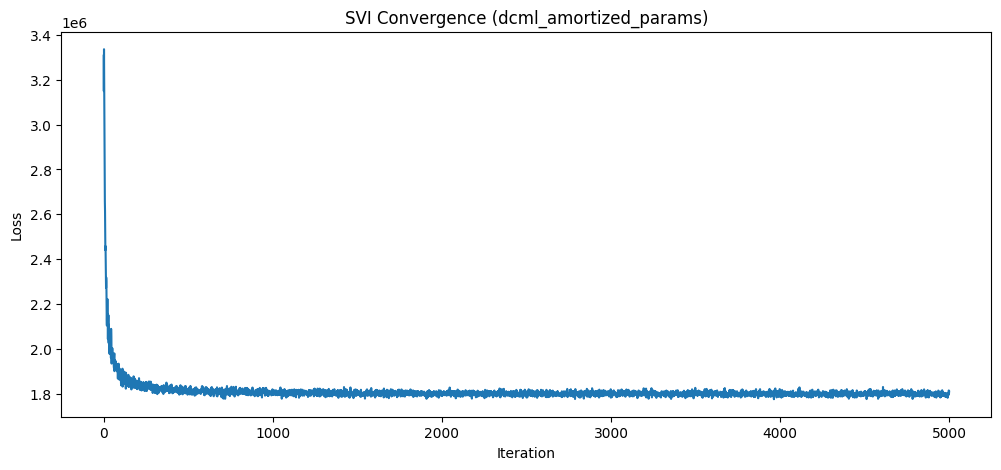

In [42]:
dcml_params, (alpha_h_history, alpha_phi_history) = infer_amortized_posteriors(npcs, len(dcml_chordtypes), dcml_obs,
                                                                              nsteps=5000, lr=0.1, plot_loss=True,
                                                                              save_as="dcml_amortized_params", collect_history=True
                                                                              )

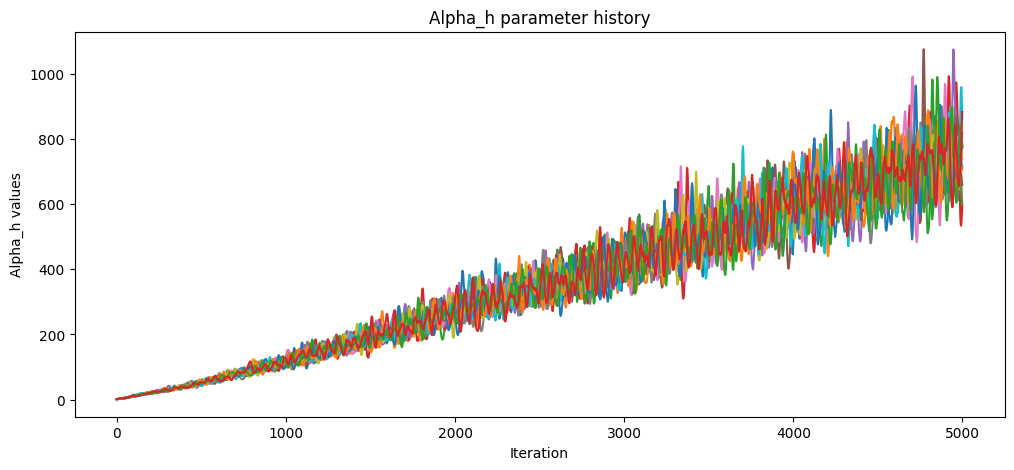

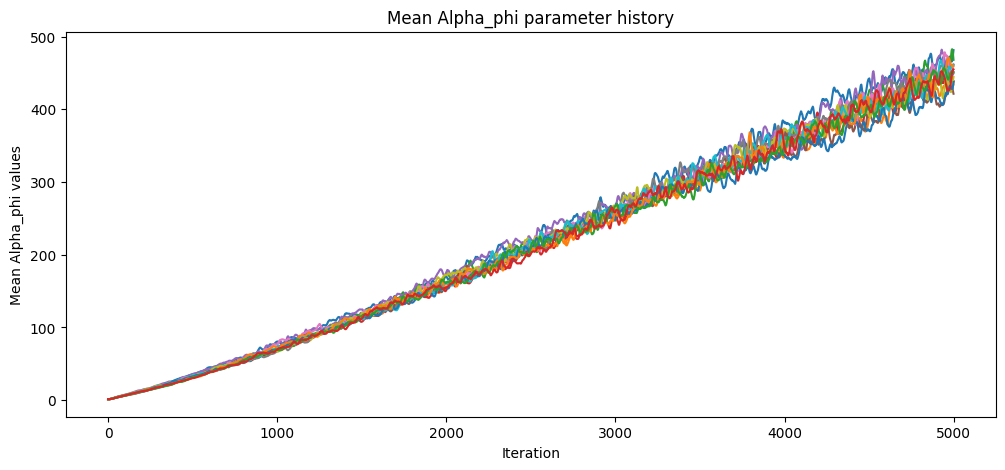

In [43]:
# Plot the parameter histories
plot_param_histories(alpha_h_history, alpha_phi_history)

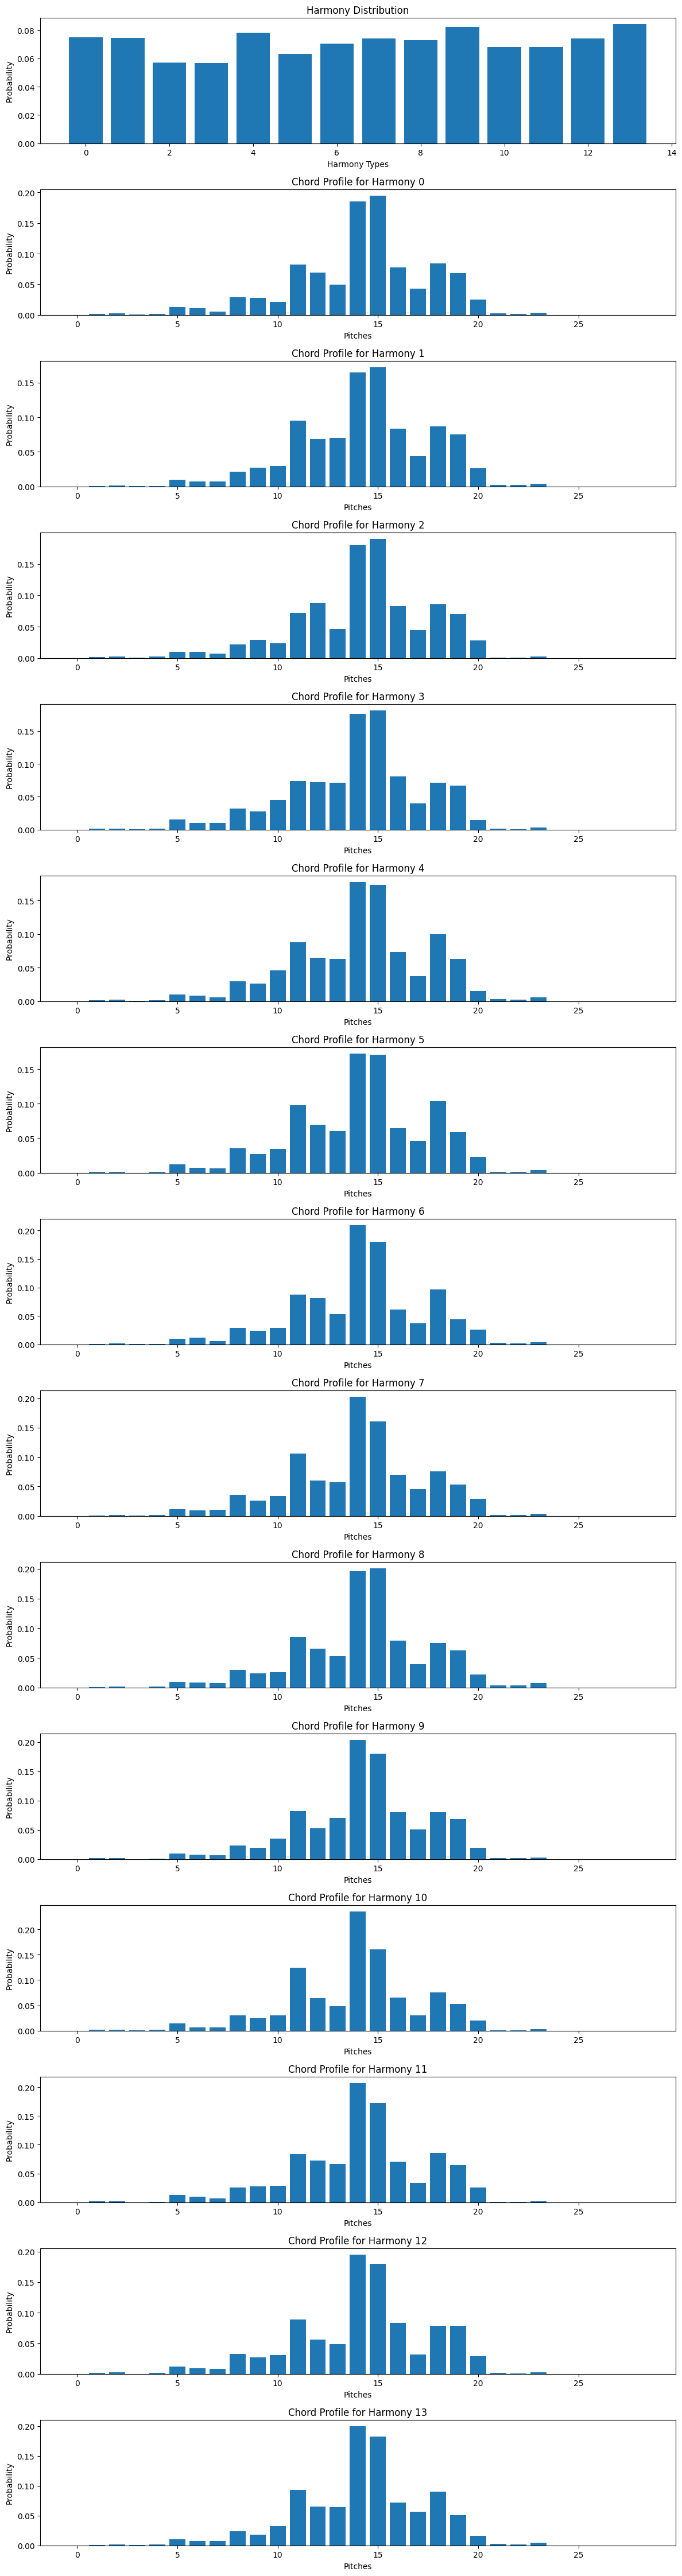

In [44]:
plot_amortized_inference_results(dcml_params, len(dcml_chordtypes), npcs, save_as="dcml_amortized_params")